# Sibship clustering

Tom Ellis, March 2017, updated June 2020

In [1]:
import faps as fp
import numpy as np
print("Created using FAPS version {}.".format(fp.__version__))


Created using FAPS version 2.6.4.


FAPS uses information in a `paternityArray` to generate plausible full-sibship configurations. This information is stored as a `sibshipCluster` object, and is the basis for almost all inference about biological processes in FAPS.

This notebook will examine how to:

1. Use a `paternityArray` to cluster offspring into plausible full-sibships.
2. Compare the relative support for different partitions structures
3. Make some basic inferences about the size and number of full sibships, and who is related to whom.

Note that this tutorial only deals with the case where you have a single maternal family. If you have multiple families, you can apply what is here to each one, but you'll have to iterate over those families. See the specific [tutorial](https://fractional-analysis-of-paternity-and-sibships.readthedocs.io/en/latest/tutorials/07_dealing_with_multiple_half-sib_families.html) on that.

## Generating a `sibshipCluster` object

We will begin by generating a population of 100 adults with 50 loci.

In [2]:
np.random.seed(867)
allele_freqs = np.random.uniform(0.3,0.5,50)
adults = fp.make_parents(100, allele_freqs, family_name='a')

We take the first individal as the mother and mate her to four males, to create three full sibships of five offspring. We then generate a `paternityArray` based on the genotype data.

In [3]:
progeny = fp.make_sibships(adults, 0, [1,2,3], 5, 'x')
mothers = adults.subset(progeny.mothers)
patlik  = fp.paternity_array(progeny, mothers, adults, mu = 0.0015, missing_parents=0.01)

It is straightforward to cluster offspring into full sibships. For now we'll stick with the default number of Monte Carlo draws.

In [4]:
sc = fp.sibship_clustering(patlik)

The default number of Monte Carlo draws is 1000, which seems to work in most cases. I have dropped it to 100 in cases where I wanted to call `sibship_clustering` many times, such as in an MCMC loop, when finding every possible candidate wasn't a priority. You could also use more draws if you really wanted to be sure you had completely sampled the space of compatible candidate fathers. Speeds are unlikely to increase linearly with number of draws:

In [5]:
%timeit fp.sibship_clustering(patlik, ndraws=100)
%timeit fp.sibship_clustering(patlik, ndraws=1000)
%timeit fp.sibship_clustering(patlik, ndraws=10000)

13.4 ms ± 603 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
24.2 ms ± 81.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
205 ms ± 4.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We discussed this in figure 5 of the FAPS paper should you be interested in more on this.

## Sibling relationships

Sibship clustering calculates likelihoods that each pair of offspring are full siblings, then builds a dendrogram from this. We can visualise this dendrogram if we so wish, although the output is not pretty.

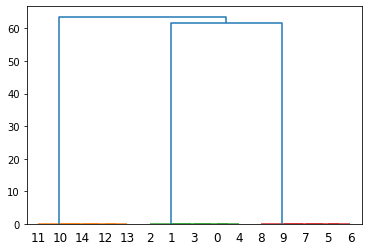

In [6]:
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

dendrogram(sc.linkage_matrix)
plt.show()

Offspring individuals are labelled by their *index* in the array. Since full sibships are of size five we should expect to see clusters of {0,1,2,3,4}, {5,6,7,8,9} and {10,11,12,13,14}. This is indeed what we do see. What is difficult to see on the dendrogram are the branches connecting full siblings at the very bottom of the plot. If we bisect this dendrogram at different places on the y-axis we can infer different ways to partition the offspring into full siblings.

`sc` is an object of class `sibshipCluster` that contains various information about the array. Of primary interest are the set of partition structures inferred from the dendrogram. There are sixteen partitions - one for each individual in the array (i.e. one for each bifurcation in the dendrogram).

In [5]:
sc.partitions

array([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2],
       [ 3,  3,  3,  3,  3,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2],
       [ 4,  4,  4,  4,  4,  1,  1,  2,  1,  1,  3,  3,  3,  3,  3],
       [ 5,  5,  5,  5,  5,  1,  1,  3,  1,  2,  4,  4,  4,  4,  4],
       [ 5,  6,  5,  5,  5,  1,  1,  3,  1,  2,  4,  4,  4,  4,  4],
       [ 6,  7,  6,  6,  6,  1,  1,  3,  1,  2,  4,  5,  4,  4,  4],
       [ 7,  8,  7,  7,  7,  1,  1,  4,  2,  3,  5,  6,  5,  5,  5],
       [ 8,  9,  8,  8,  8,  1,  2,  5,  3,  4,  6,  7,  6,  6,  6],
       [ 8, 10,  9,  8,  8,  1,  2,  5,  3,  4,  6,  7,  6,  6,  6],
       [ 8, 11, 10,  9,  8,  1,  2,  5,  3,  4,  6,  7,  6,  6,  6],
       [ 9, 12, 11, 10,  9,  1,  2,  5,  3,  4,  7,  8,  6,  6,  6],
       [10, 13, 12, 11, 10,  1,  2,  5,  3,  4,  8,  9,  6,  6,  7],
       [11, 14, 13, 12, 11,  1,  2,  5,  3,  4,  9, 10,  6,  7,  8],
       [11, 15, 14, 13, 12,  1,  2

What is key about partition structures is that each symbol represents a *unique but arbitrary* family identifier. For example in the third row we see the true partition structure, with individuals grouped into three groups of five individuals.

In [6]:
sc.partitions[2]

array([3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2], dtype=int32)

Beyond denoting who is in a family with whom, the labels are arbitrary, with no meaningful order. This partition would be identical to `[0,0,0,0,0,1,1,1,1,1,2,2,2,2,2]` or `[10,10,10,10,10,7,7,7,7,7,22,22,22,22,22]` for example.

Each partition is associated with a log likelihood and equivalent log probability. We can see from both scores that the third partition is most consistent with the data. This is of course the true partition.

In [7]:
print(sc.lik_partitions) # log likelihood of each partition
print(np.exp(sc.prob_partitions)) # probabilities of each partition

[-4.23560188e+02 -1.94067281e+02 -2.70500804e-04 -8.55784873e+00
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf            -inf
            -inf            -inf            -inf]
[1.12248824e-184 5.22016966e-085 9.99807953e-001 1.92047026e-004
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000]


We also see that the first and second partitions have non-zero, but small likelihoods. Parititons 5-8 have negative infinity log likelihood - they are incompatible with the data. These partitions split up true full siblings, and there is no way to reconcile this with the data. In real world situations such partitions might have non-zero likelihoods if they were an unrelated candidate male compatible with one or more offspring through chance alone.

In some cases there can be rounding error when log probabilities are exponentiated and probabilities do not sum to one. This is classic machine error, and the reason it is good to work with log values wherever possible. We can check:

In [8]:
np.exp(sc.prob_partitions).sum()

0.9999999999999999

You can directly call the most likely partition. This is somewhat against the spirit of fractional analyses though...

In [9]:
sc.mlpartition

array([3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2], dtype=int32)

For information about fine scale relationships, `sc.full_sib_matrix()` returns an $n*n$ matrix, where $n$ is the number of offspring. Each element describes the (log) probability that a pair of individuals are full siblings, averaged over partition structures and paternity configurations. If we plot this using a heatmap you can clearly see the five full sibships jump out as blocks of yellow (>90% probability of being full siblings) against a sea of purple (near zero probability of being full siblings).

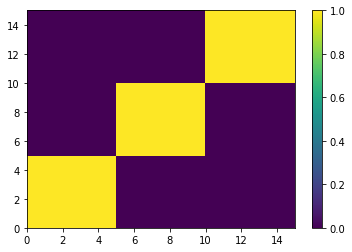

In [10]:
sibmat = sc.full_sib_matrix()
plt.pcolor(np.exp(sibmat))
plt.colorbar()
plt.show()

Note that real datasets seldom look this tidy!

## Inferring family structure

For this section we will simulate a slightly more interesting family structure. This block of code creates a half-sib array of 15 offspring from five fathers, where each father contributes five, four, three, two and one offspring respectively. It then performs sibship clustering on the array. We use 1000 candidate males and 50 loci.

In [11]:
# Lists indexing sires and dams
sires = [1]*5 + [2]*4 + [3]*3 + [4]*2 +[5]*1
dam   = [0] * len(sires)

np.random.seed(542)
allele_freqs = np.random.uniform(0.3,0.5,30)
adults  = fp.make_parents(1000, allele_freqs, family_name='a')
progeny = fp.make_offspring(adults, dam_list=dam, sire_list=sires)
mothers = adults.subset(progeny.mothers)

patlik  = fp.paternity_array(progeny, mothers, adults, mu= 0.0015, missing_parents=0.01)
sc = fp.sibship_clustering(patlik)

### Number of families

We saw before that we could call a list of valid partitions for `sc` using `sc.partitions`. The output is not terribly enlightening on its own, however. We could instead ask how probable it is that there are *x* full sibships in the array, integrating over all partition structures. Here each number is the probability that there are 1, 2, ..., 15 families.

In [12]:
sc.nfamilies()

array([6.09528844e-103, 4.68985495e-065, 6.19307208e-047, 9.97886140e-007,
       7.57314645e-001, 2.17024167e-001, 2.47376286e-002, 9.22561282e-004,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000])

We could show the same information graphically. Its clear that almost all the probability denisty is around $x=5$ families.

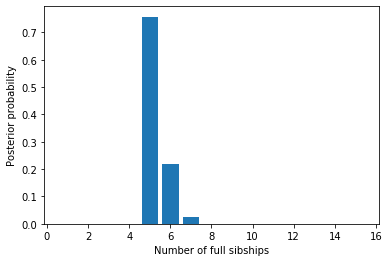

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
#ax.bar(np.arange(0.5, len(sc.nfamilies())+0.5), sc.nfamilies())
ax.bar(np.arange(1,16), sc.nfamilies())
ax.set_xlabel('Number of full sibships')
ax.set_ylabel('Posterior probability')
plt.show()

### Family size

We can also get the distribution of family sizes within the array, averaged over all partitions. This returns a vector of the same length as the number of offspring in the array. `family_size` returns the posterior probability of observing one or more families of size 1, 2, ... , 15. It will be clear that we are unable to distinguish a single sibship with high probability from multiple families of the same size, each with low probability; this is the price we pay for being able to integrate out uncertainty in partition structure.

In [14]:
sc.family_size()

array([2.34867440e-001, 1.94932407e-001, 1.87748944e-001, 2.30988031e-001,
       1.51463178e-001, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       2.06435736e-047, 0.00000000e+000, 2.34492747e-065, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 6.09528844e-103])

Plotting this shows that we are roughly equally likely to observe a family of sizes one, two, three, four and five. 

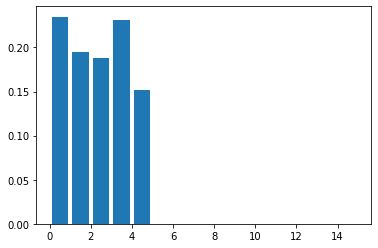

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(len(sires))+0.5, sc.family_size())

plt.show()

## Identifying fathers

### Mating events

We very frequently want to know who the fathers of the offspring were to say something about mating events. There are several levels of complexity. Firstly, you can use the `sires` method to return a list of all the males who could possibly have mated with the mother.. This is essentially identifying **mating events**, but doesn't say anything about the paternity of individual offspring. For many applications, that may be all you need because it's the mating events that are the unit of interest, not the number of offspring per se.

Once you have a `sibshipCluster` object, doing this is easy:

In [30]:
sc.sires()

,position,label,log_prob,prob,offspring
0,1,a_1,3.330669e-16,1.000000e+00,4.945498e+00
1,2,a_2,4.996004e-16,1.000000e+00,4.000000e+00
2,3,a_3,3.330669e-16,1.000000e+00,2.995992e+00
3,4,a_4,3.330669e-16,1.000000e+00,1.999999e+00
4,5,a_5,-1.164911e-01,8.900380e-01,8.872125e-01
5,17,a_17,-1.144896e+01,1.066056e-05,2.987473e-06
6,87,a_87,-2.207630e+00,1.099610e-01,1.126593e-01
7,254,a_254,-2.230188e+00,1.075082e-01,2.385890e-02
8,257,a_257,-3.580195e+00,2.787027e-02,6.023169e-03
9,288,a_288,-7.355141e+00,6.392971e-04,1.791514e-04


The columns in the output tell you several bits of information. The most interesting of these are:

1. **label** is the name of the candidate father
2. **prob** is the probability that the male sired at least one offspring with the mother, as a weighted average over partition structures. For example, 
3. **offspring** shows the expected number of offspring sired by the male, as a weighted average over partition structures. Specifically, it's the sum over rows from `prob_paternity`; see below.

Note that if you have multiple maternal families the output will look a bit different. See the [tutorial on multiple maternal families](https://fractional-analysis-of-paternity-and-sibships.readthedocs.io/en/latest/tutorials/07_dealing_with_multiple_half-sib_families.html#clustering-multiple-families) for more.

We can check this table makes sense by reviewing who the real fathers really are. This snippet gives a list of the names of the five true fathers, followed by the number of offspring sired by each.

In [21]:
np.unique(patlik.fathers, return_counts=True)

(array(['a_1', 'a_2', 'a_3', 'a_4', 'a_5'], dtype='<U5'),
 array([5, 4, 3, 2, 1]))

The first five rows of the table above show that these fathers have posterior probabilities of paternity of one or close to one, and seem to have sired the correct numbers of offspring each. Of note is that although a_1 to a_4 have posterior probabilities of exactly one, the posterior probability for a_5 is slightly less than one. This is because the first four fathers sired multiple offspring, and there is shared information between siblings about the father, but this is not the case for father a_5.

After the true fathers there are a long list of extra candidates with very low posterior probabilities of paternity. In this case we know they are not true fathers, but in real life we would not, and we would like to account for this uncertainty. 

### Paternity of individuals

If you are interested in the paternity of individual offspring we can look at the output of the `prob_paternity` method of `sibshipCluster` objects. This returns a matrix with a row for every offspring and a column for every candidate, plus an extra column for absent fathers.

In [32]:
sc.prob_paternity().shape

(15, 1001)

Rows sum to one, so each row can be interpreted as a Dirichlet distribution:

In [44]:
np.exp(sc.prob_paternity()).sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

This is similar to `patlik.prob_array()` in that each element is interpreted as the probability of that the offspring in a given row was sired by the father in a given column, except that the elements in the matrix are now averaged over partition structures. For example, compare the rows for the first five offspring, who are all full siblings, for the first three candidates before and after clustering into sibships:

In [46]:
# Before
patlik.prob_array()[:5, :3]

array([[-3.38800429e+01, -1.40506263e-01, -3.16818671e+01],
       [-2.86253234e+01, -3.09240212e-03, -3.13437568e+01],
       [-3.96961398e+01, -1.51388217e-01, -3.16927491e+01],
       [-3.30893781e+01, -3.77506793e-02, -2.56419899e+01],
       [-2.81879852e+01, -2.53663440e-01, -3.24829336e+01]])

In [47]:
# After 
sc.prob_paternity()[:5, :3]

array([[-1.02401752e+02, -1.11022302e-16, -9.54746212e+01],
       [-1.02401752e+02, -1.11022302e-16, -9.54746212e+01],
       [-4.66844966e+01, -1.29615385e-04, -3.86811058e+01],
       [-1.02401752e+02, -1.11022302e-16, -9.54746212e+01],
       [-2.96039788e+01, -5.59067869e-02, -3.38989272e+01]])

In both cases you can see that the mother has low support as a father (left-most column), and the true father (middle column) has the highest support (these are log probabilities, so negative values closest to zero reflect stronger support). However, comparing the two show the added power gained from incorporating information about sibling relationships into identifying the fathers; log probabilties for the true father are orders of magnitude smaller in the second array than the first.
